In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib.pyplot as plt

sys.path.append('../')
from preprocessing import *
from unmixing_algorithms import *
from extinctions import *
from plotting_parameters import *

### Load extinction spectra of endmembers

In [2]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)
scatter_ray = (band_centers/500)**(-4)
scatter_simple = (band_centers/500)**(-1.2)

# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")


extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])


M = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat)).T
endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat"]

M_ones = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones)).T
endmember_labels_ones = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "ones"]

M_ones_scatter = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones, scatter_ray)).T
endmember_labels_ones_scatter = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "ones", "scatter"]

M_scatter = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_ray)).T
# endmember_labels_scatter = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat", "scatter"]
endmember_labels_scatter = ["$c_{oxCytc}$", "$c_{redCytc}$", "$c_{oxCytb}$", "$c_{redCytb}$", "$c_{oxCCO}$", "$c_{redCCO}$", "$c_{Hb}$", "$c_{HbO_2}$", "$c_{water}$", "$c_{lipid}$", "$a'$"]
M_scatter_simple = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_simple)).T

M_reduced = np.vstack((cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, scatter_simple)).T
endmember_labels_reduced = ["$c_{oxCCO}$", "$c_{redCCO}$", "$c_{Hb}$", "$c_{HbO_2}$", "$c_{water}$", "$a'$"]

### Load a HeliCoid image

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


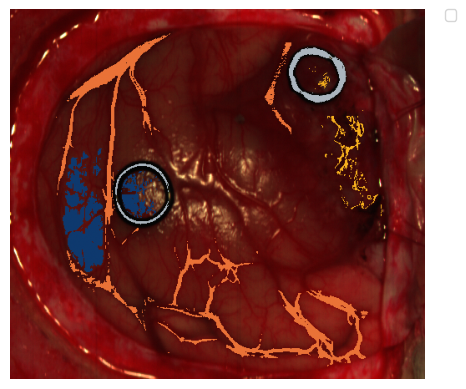

In [4]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)


img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_smooth = smooth_spectral(img_calib, 5)
# img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), keepdims=True)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

### Plotting functions

In [14]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def plot_concentrations(c, endmember_labels=None, figsize=(15,9)):
    N = c.shape[2]
    if N < 5:
        fig, axs = plt.subplots(1, N, figsize=figsize)
        for i in range(N):
            axs[i].imshow(c[:,:,i], cmap=tum_cmap)
            axs[i].set_title(endmember_labels[i])
            axs[i].axis("off")
            # add colorbar
            divider = make_axes_locatable(axs[i])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(axs[i].images[0], cax=cax)
    else:
        fig, axs = plt.subplots(int(np.ceil(N/5)), 5, figsize=figsize)
        for i in range(N):
            axs[i//5,i%5].imshow(c[:,:,i], cmap=tum_cmap)
            axs[i//5,i%5].set_title(endmember_labels[i])
            axs[i//5,i%5].axis("off")
            # add colorbar
            divider = make_axes_locatable(axs[i//5,i%5])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(axs[i//5,i%5].images[0], cax=cax)
    _ = plt.tight_layout()
    return fig, axs

def plot_error_img(err):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    err_img = plt.imshow(np.linalg.norm(err, axis=2), cmap=tum_cmap)
    print(np.linalg.norm(err.flatten()))
    fig.colorbar(err_img, ax=ax)
    return fig, ax

def check_fit(c, M, abs, endmember_labels, nrows=3, ncols=4, figsize=(15,7), img=None, colors=None):
    np.random.seed(42)
    # plot nrows*ncols random pixel spectra as well as the fit
    m, l, k = abs.shape
    idxs_1 = np.linspace(100, m-100, nrows, dtype=int)
    idxs_2 = np.linspace(100, l-100, ncols, dtype=int)
    n = M.shape[1]
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    if img is not None:
        fig2, ax2 = plt.subplots(1,1, figsize=(5,5))
        ax2.imshow(img)
    for i in range(nrows*ncols):
        idx_1 = idxs_1[i//ncols]
        idx_2 = idxs_2[i%ncols]
        if img is not None:
            ax2.plot(idx_2, idx_1, color=tum_blue_brand, marker="o", markersize=7, linewidth=10)
            ax2.axis('off')
        axs[i//ncols,i%ncols].plot(band_centers, abs[idx_1,idx_2,:], label="A", color="r", linewidth=2)
        axs[i//ncols,i%ncols].plot(band_centers, M @ c[idx_1,idx_2,:], label="fit", color="k", linewidth=2)
        axs[i//ncols,i%ncols].set_xlim(520,900)
        axs[i//ncols,i%ncols].set_xlabel("Wavelength (nm)")
        if i%ncols == 0:
            axs[i//ncols,i%ncols].set_ylabel("Intensity")
        for j in range(n):
            if colors is not None:
                axs[i//ncols,i%ncols].plot(band_centers, M[:,j]*c[idx_1,idx_2,j], label=endmember_labels[j], linewidth=1, color=colors[j])
            else: 
                axs[i//ncols,i%ncols].plot(band_centers, M[:,j]*c[idx_1,idx_2,j], label=endmember_labels[j], linestyle="--", linewidth=0.5)
    # place legend centered below the subplots
    axs[nrows-1,ncols//2].legend(loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=4)
    return fig, axs

### Unmixing data

Unconstrained Least square solver

483.9987


Text(0.5, 0.98, 'Example spectra and fit with simple scatter term')

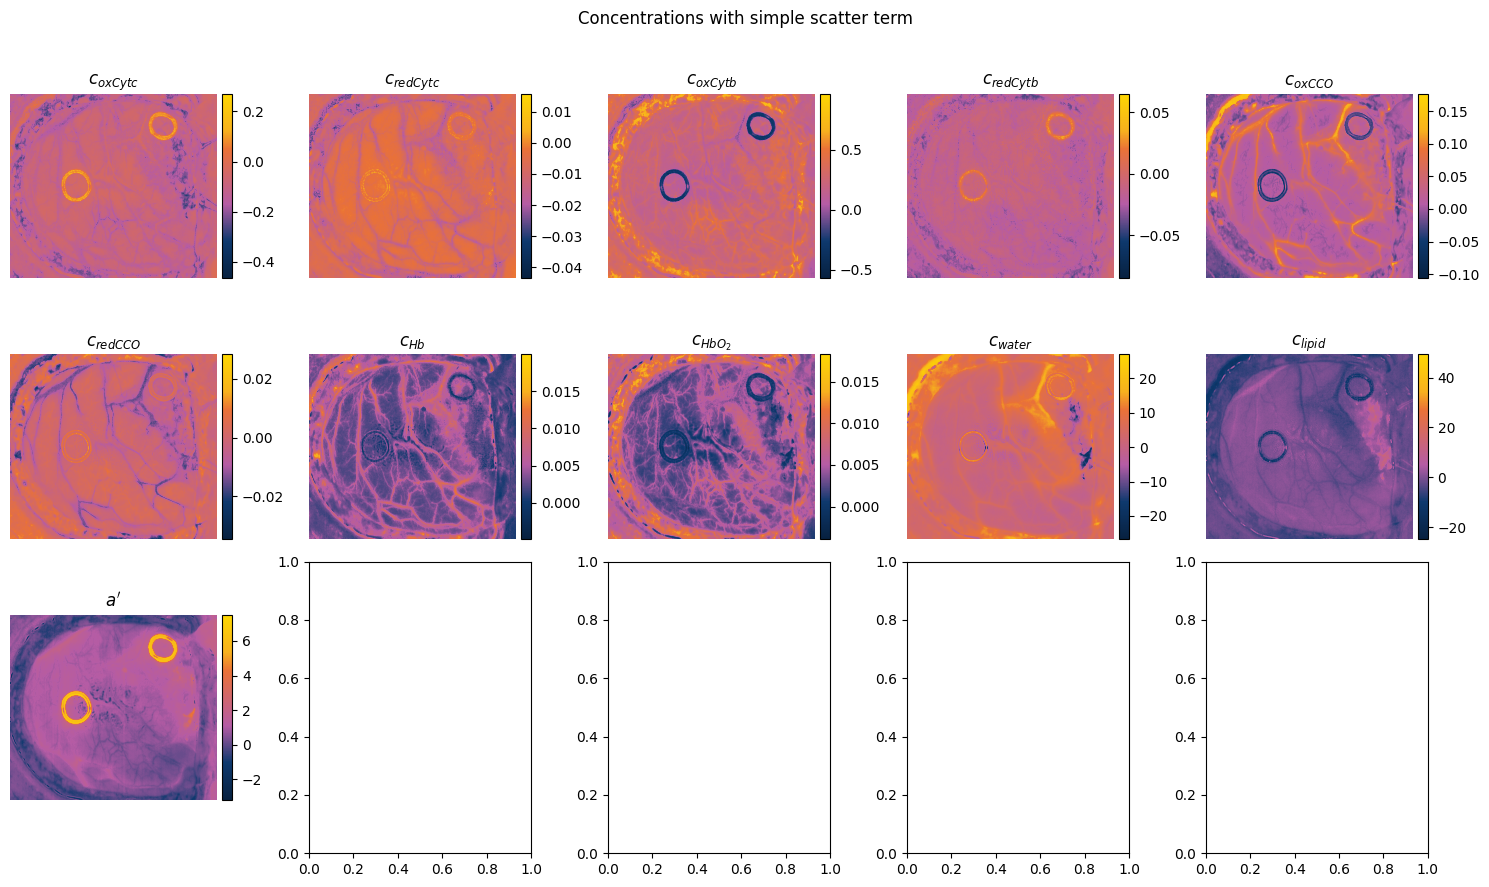

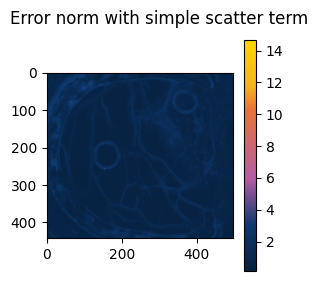

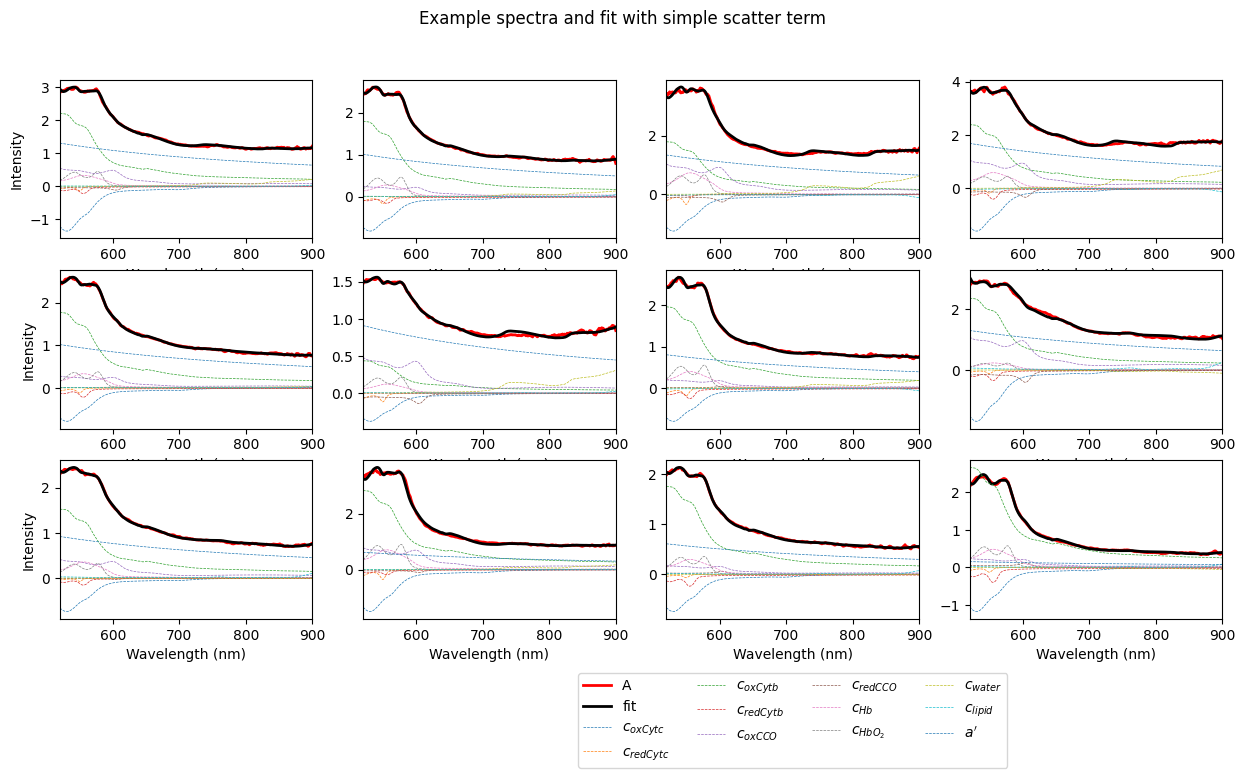

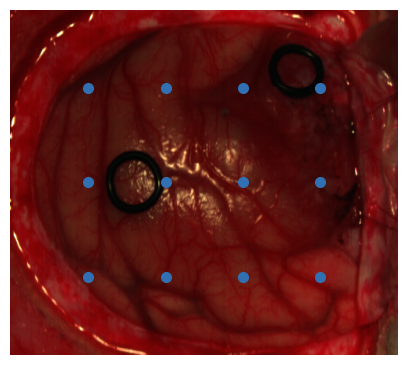

In [15]:
# c, err = unmix_LS_unconstrained(M, absorbance)

# c_ones, err_ones = unmix_LS_unconstrained(M_ones, absorbance)

# c_ones_scatter, err_ones_scatter = unmix_LS_unconstrained(M_ones_scatter, absorbance)

# c_scatter, err_scatter = unmix_LS_unconstrained(M_scatter, absorbance)

M_scatter_simple_smooth = smooth_spectral(M_scatter_simple.T,5).T
c_scatter_simple, err_scatter_simple = unmix_LS_unconstrained(M_scatter_simple_smooth, absorbance)

# plot the concentrations
# fig, axs = plot_concentrations(c, endmember_labels, figsize=(30,10))
# fig.suptitle("Concentrations")
# fig.tight_layout()
# fig, axs = plot_concentrations(c_ones, endmember_labels_ones, figsize=(30,15))
# fig.suptitle("Concentrations with ones term")
# fig.tight_layout()
# fig, axs = plot_concentrations(c_ones_scatter, endmember_labels_ones_scatter, figsize=(30,15))
# fig.suptitle("Concentrations with ones and Rayleigh scatter term")
# fig.tight_layout()
# fig, axs = plot_concentrations(c_scatter, endmember_labels_scatter, figsize=(30,15))
# fig.suptitle("Concentrations with Rayleigh scatter term")
# fig.tight_layout()
fig, axs = plot_concentrations(c_scatter_simple, endmember_labels_scatter, figsize=(15,9))
fig.suptitle("Concentrations with simple scatter term")
fig.tight_layout()

# plot the fitting error
# fig, ax = plot_error_img(err)
# fig.suptitle("Error norm")
# fig, ax = plot_error_img(err_ones)
# fig.suptitle("Error norm with ones term")
# fig, ax = plot_error_img(err_ones_scatter)
# fig.suptitle("Error norm with ones and Rayleigh scatter term")
# fig, ax = plot_error_img(err_scatter)
# fig.suptitle("Error norm with Rayleigh scatter term")
fig, ax = plot_error_img(err_scatter_simple)
fig.suptitle("Error norm with simple scatter term")

# plot example pixel spectra and the fit
# fig, axs = check_fit(c, M, absorbance, endmember_labels)
# fig.suptitle("Example spectra and fit")
# fig, axs = check_fit(c_ones, M_ones, absorbance, endmember_labels_ones)
# fig.suptitle("Example spectra and fit with ones term")
# fig, axs = check_fit(c_ones_scatter, M_ones_scatter, absorbance, endmember_labels_ones_scatter)
# fig.suptitle("Example spectra and fit with ones and Rayleigh scatter term")
# fig, axs = check_fit(c_scatter, M_scatter, absorbance, endmember_labels_scatter)
# fig.suptitle("Example spectra and fit with Rayleigh scatter term")
fig, axs = check_fit(c_scatter_simple, M_scatter_simple_smooth, absorbance, endmember_labels_scatter, img=get_rgb(img))
fig.suptitle("Example spectra and fit with simple scatter term")

nonnegative LSS

100%|██████████| 443/443 [00:09<00:00, 47.79it/s]


789.7825696413776
870.0332060504347


Text(0.5, 0.98, 'Example spectra and fit with reduced endmember numbers')

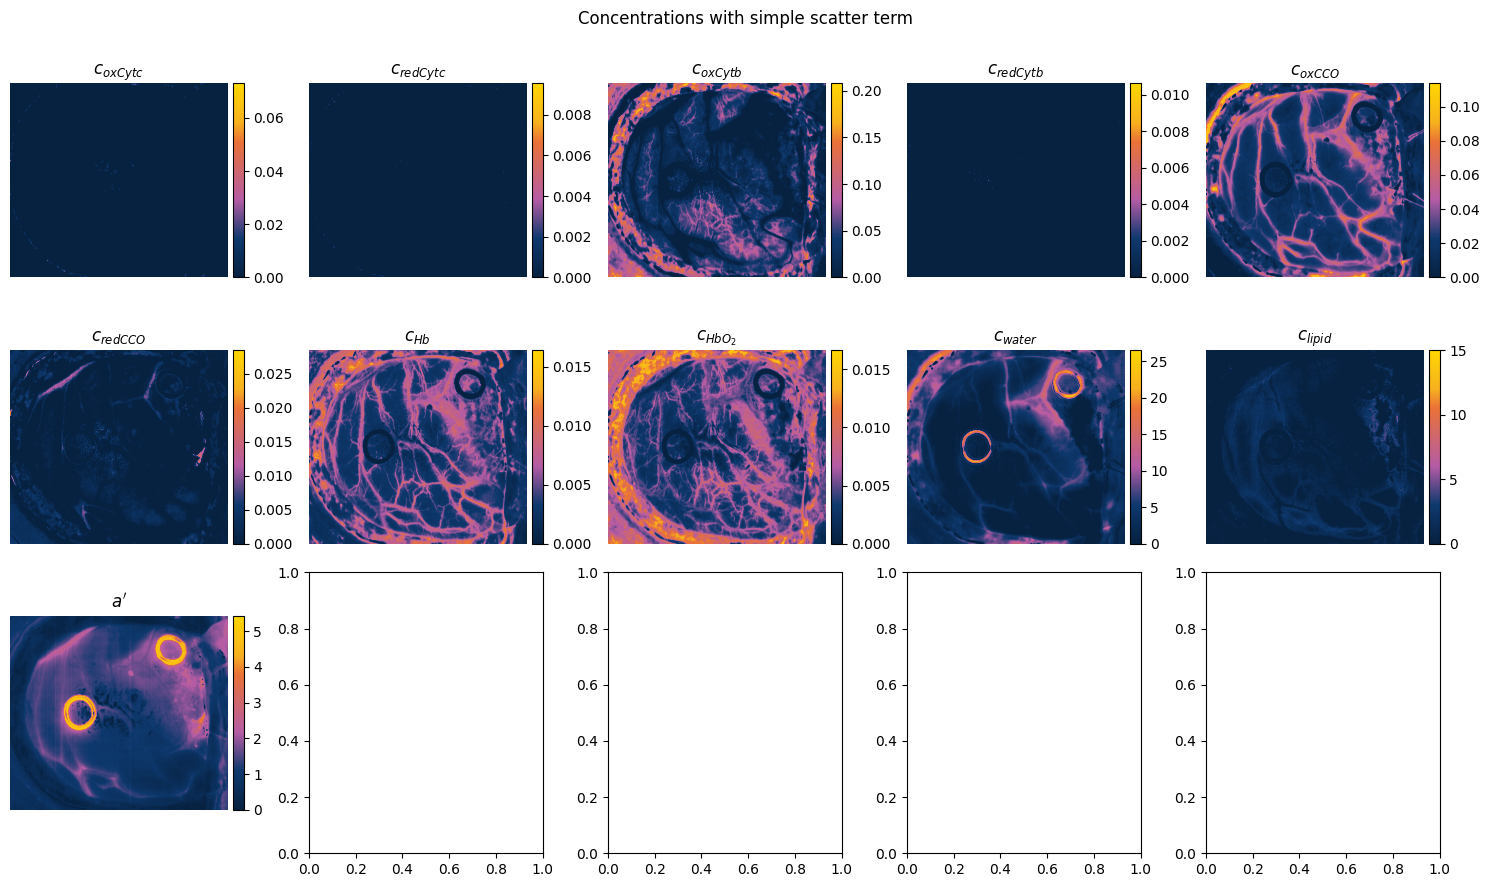

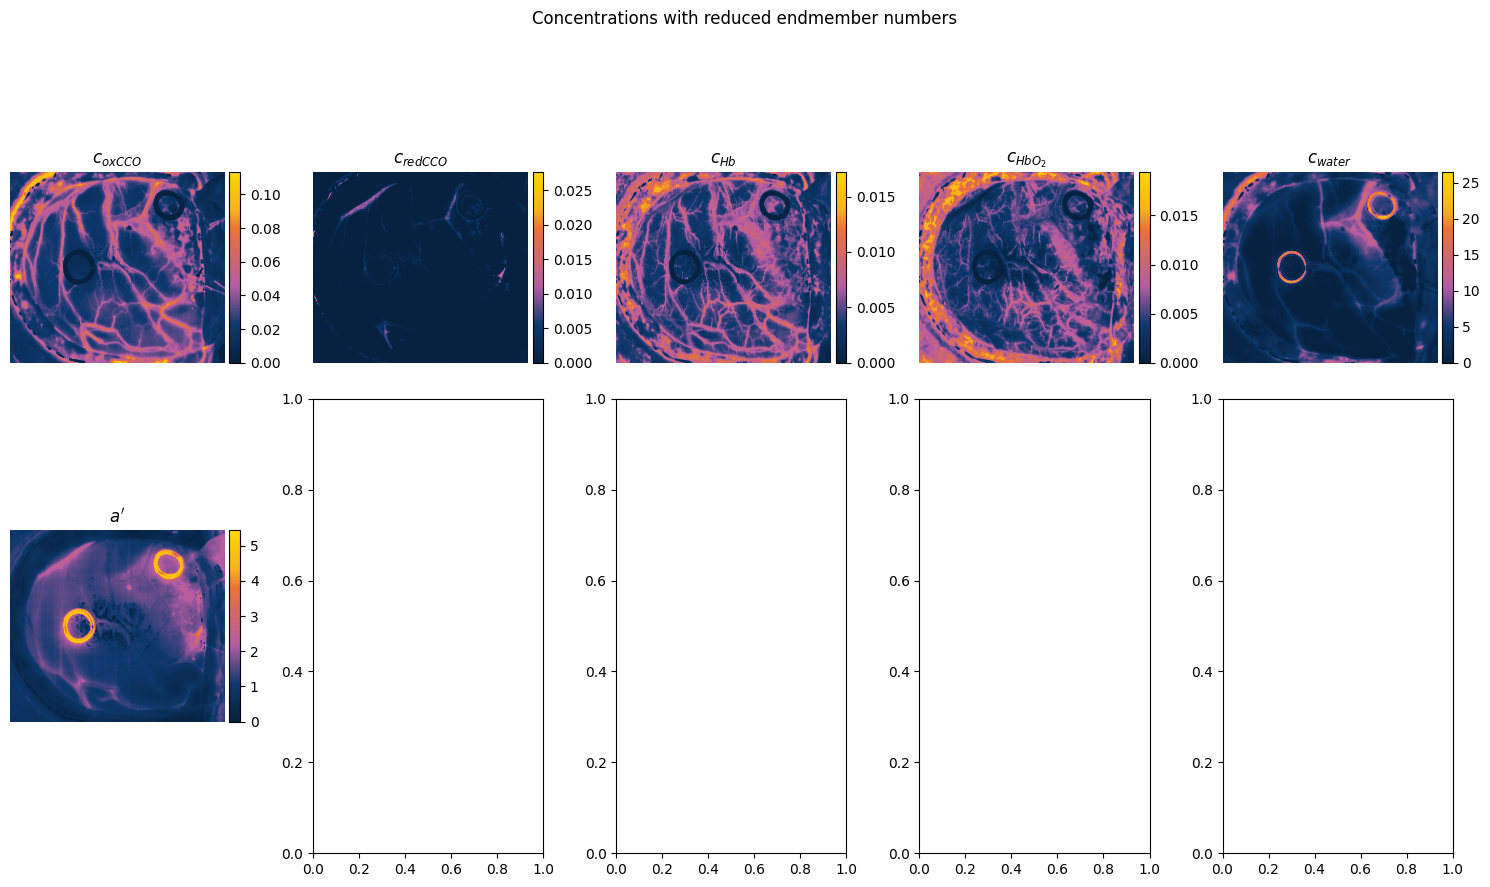

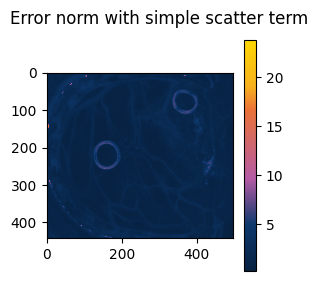

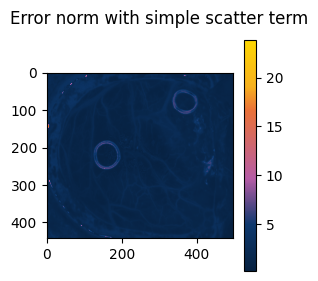

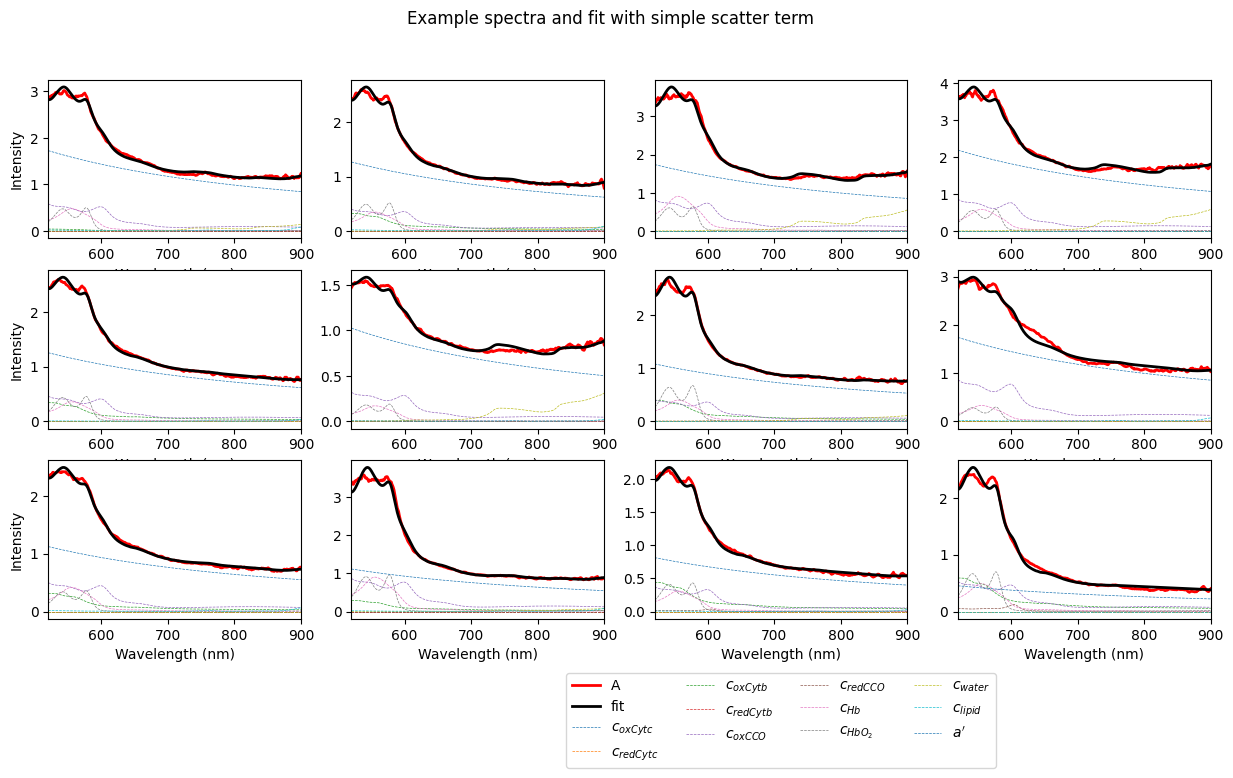

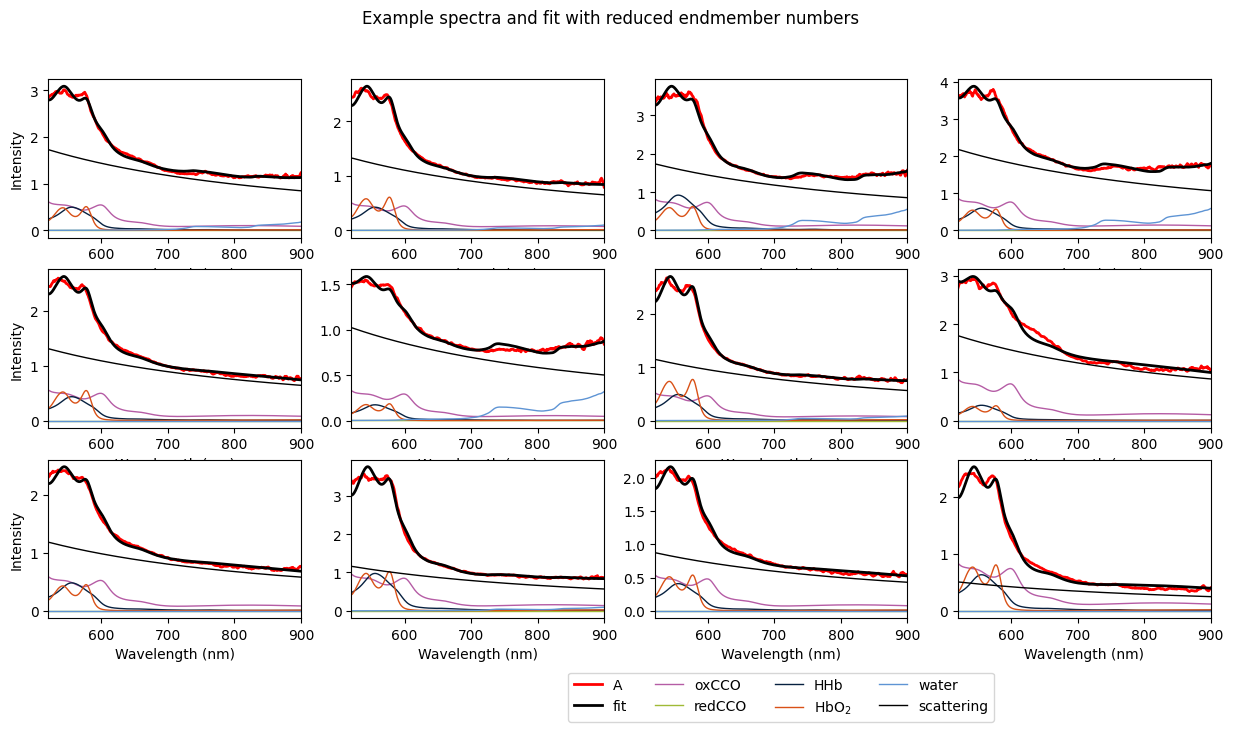

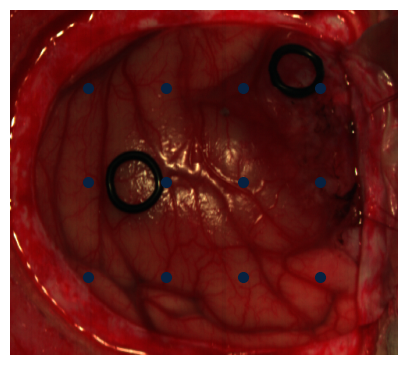

In [12]:
# c, err = unmix_LS_nonnegative(M, absorbance)

# c_ones, err_ones = unmix_LS_nonnegative(M_ones, absorbance)

# c_ones_scatter, err_ones_scatter = unmix_LS_nonnegative(M_ones_scatter, absorbance)

# c_scatter, err_scatter = unmix_LS_nonnegative(M_scatter, absorbance)

M_scatter_simple_smooth = smooth_spectral(M_scatter_simple.T,5).T
c_scatter_simple, err_scatter_simple = unmix_LS_nonnegative(M_scatter_simple_smooth, absorbance)

M_reduced_smooth = smooth_spectral(M_reduced.T,5).T
c_reduced, err_reduced = unmix_LS_nonnegative(M_reduced, absorbance)


# plot the concentrations
# fig, axs = plot_concentrations(c, endmember_labels, figsize=(30,10))
# fig.suptitle("Concentrations")
# fig.tight_layout()
# fig, axs = plot_concentrations(c_ones, endmember_labels_ones, figsize=(30,15))
# fig.suptitle("Concentrations with ones term")
# fig.tight_layout()
# fig, axs = plot_concentrations(c_ones_scatter, endmember_labels_ones_scatter, figsize=(30,15))
# fig.suptitle("Concentrations with ones and Rayleigh scatter term")
# fig.tight_layout()
# fig, axs = plot_concentrations(c_scatter, endmember_labels_scatter, figsize=(30,15))
# fig.suptitle("Concentrations with Rayleigh scatter term")
# fig.tight_layout()
fig, axs = plot_concentrations(c_scatter_simple, endmember_labels_scatter, figsize=(15,9))
fig.suptitle("Concentrations with simple scatter term")
fig.tight_layout()
fig, axs = plot_concentrations(c_reduced, endmember_labels_reduced, figsize=(15,9))
fig.suptitle("Concentrations with reduced endmember numbers")
fig.tight_layout()

# plot the fitting error
# fig, ax = plot_error_img(err)
# fig.suptitle("Error norm")
# fig, ax = plot_error_img(err_ones)
# fig.suptitle("Error norm with ones term")
# fig, ax = plot_error_img(err_ones_scatter)
# fig.suptitle("Error norm with ones and Rayleigh scatter term")
# fig, ax = plot_error_img(err_scatter)
# fig.suptitle("Error norm with Rayleigh scatter term")
fig, ax = plot_error_img(err_scatter_simple)
fig.suptitle("Error norm with simple scatter term")
fig, ax = plot_error_img(err_reduced)
fig.suptitle("Error norm with simple scatter term")

# plot example pixel spectra and the fit
# fig, axs = check_fit(c, M, absorbance, endmember_labels)
# fig.suptitle("Example spectra and fit")
# fig, axs = check_fit(c_ones, M_ones, absorbance, endmember_labels_ones)
# fig.suptitle("Example spectra and fit with ones term")
# fig, axs = check_fit(c_ones_scatter, M_ones_scatter, absorbance, endmember_labels_ones_scatter)
# fig.suptitle("Example spectra and fit with ones and Rayleigh scatter term")
# fig, axs = check_fit(c_scatter, M_scatter, absorbance, endmember_labels_scatter)
# fig.suptitle("Example spectra and fit with Rayleigh scatter term")
fig, axs = check_fit(c_scatter_simple, M_scatter_simple_smooth, absorbance, endmember_labels_scatter)
fig.suptitle("Example spectra and fit with simple scatter term")
endmember_colors = [tum_pink, tum_green, tum_blue_dark, tum_red_dark, tum_blue_light, 'k']
labels = ["oxCCO", "redCCO", "HHb", "HbO$_2$","water","scattering"]
fig, axs = check_fit(c_reduced, M_reduced_smooth, absorbance, labels,img=get_rgb(img),  colors=endmember_colors)
fig.suptitle("Example spectra and fit with reduced endmember numbers")

### Projection + LMM

In [24]:
n,k = extinction_array.shape
extinction_array_bilinear_water = np.zeros((n, k))
for i in range(n):
        extinction_array_bilinear_water[i,:] = extinction_array[i,:] * water

Cytochrome c oxibase 

100%|██████████| 443/443 [00:03<00:00, 117.04it/s]


519.0270173024143
(443, 497, 2)


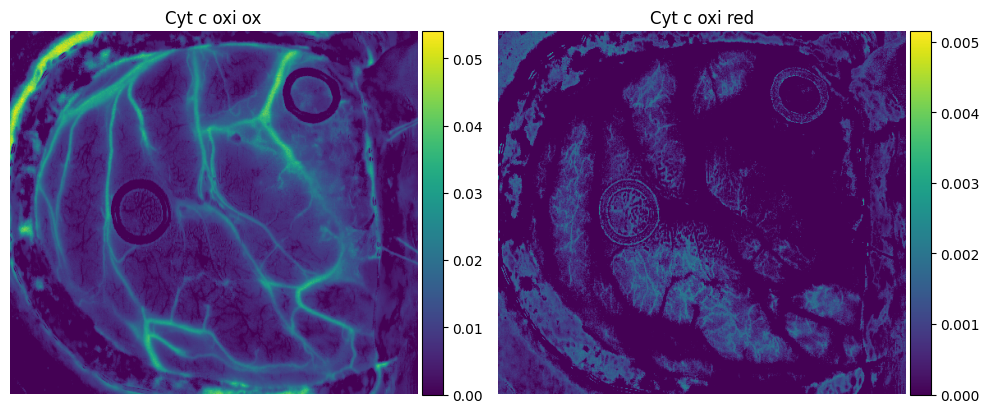

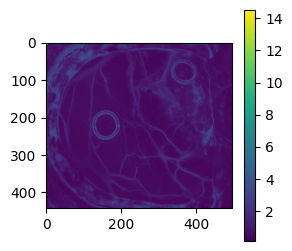

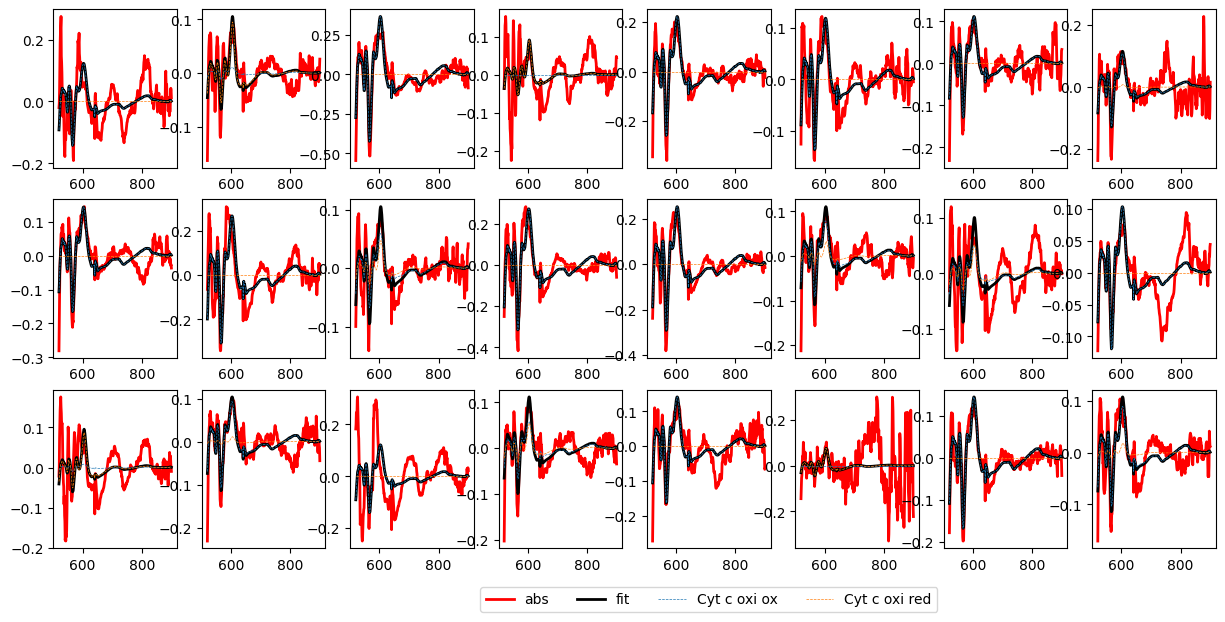

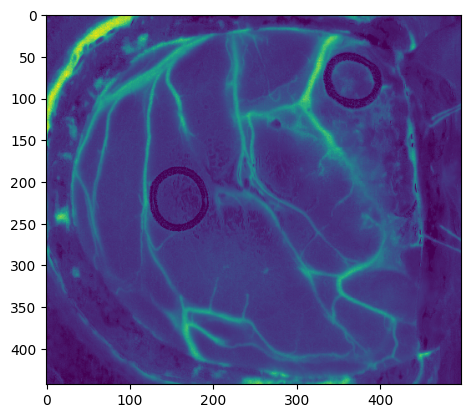

In [13]:
endmembers_proj_cyt_oxi = np.vstack((cyt_b_ox, cyt_b_red, cyt_c_ox, cyt_c_red, hb, hbo2, water, fat, ones))
endmembers_unmix_cyt_oxi = np.vstack((cyt_oxi_ox, cyt_oxi_red))
absorbance_cyt_oxi_proj, endmembers_unmix_cyt_oxi_proj = project_absorbance(absorbance, endmembers_proj_cyt_oxi, endmembers_unmix_cyt_oxi, device="cuda")

M = endmembers_unmix_cyt_oxi_proj.T
c_cyt_oxi, err_cyt_oxi = unmix_LS_nonnegative(M, absorbance_cyt_oxi_proj)

endmember_labels=["Cyt c oxi ox", "Cyt c oxi red"]
plot_concentrations(c_cyt_oxi, endmember_labels, figsize=(10,5))

plot_error_img(err_cyt_oxi)

check_fit(c_cyt_oxi, M, absorbance_cyt_oxi_proj, endmember_labels)

print(c_cyt_oxi.shape)
plt.figure()
plt.imshow(c_cyt_oxi[:,:,0]+5*c_cyt_oxi[:,:,1])

cytochrome c

 20%|██        | 89/443 [00:00<00:02, 142.18it/s]

100%|██████████| 443/443 [00:03<00:00, 142.61it/s]


641.6518537823538


(<Figure size 1500x700 with 24 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >]], dtype=object))

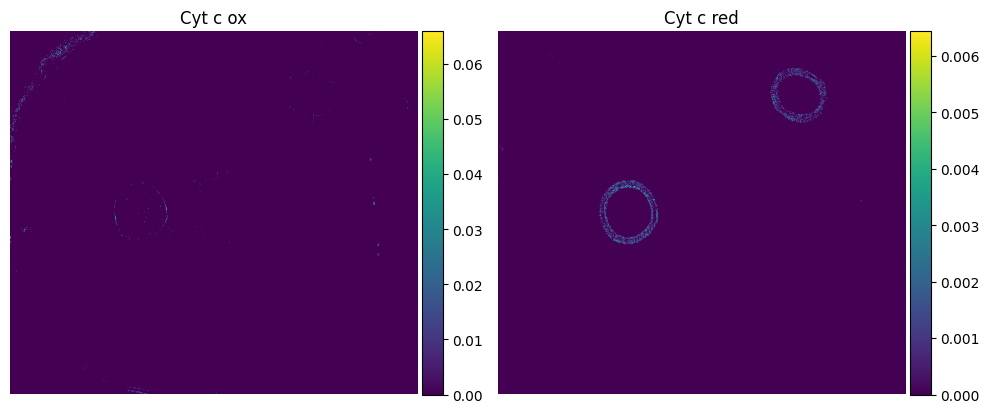

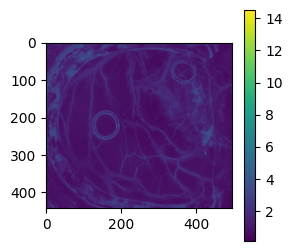

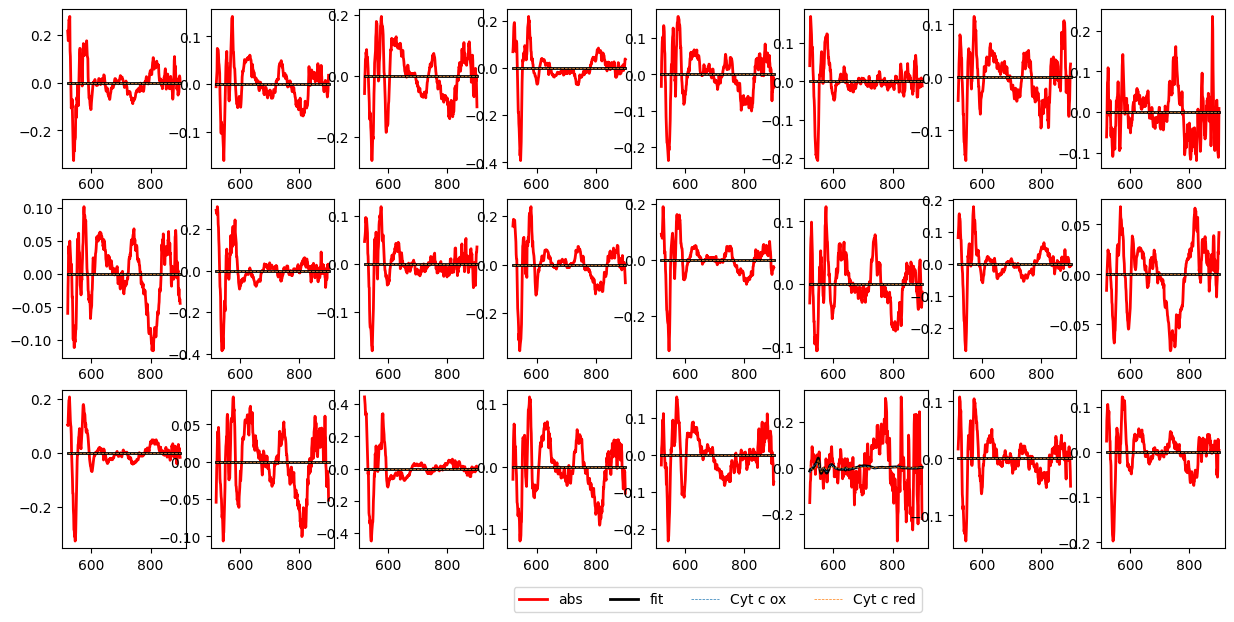

In [6]:
n,k = extinction_array.shape
extinction_array_bilinear_water = np.zeros((n, k))
for i in range(n):
        extinction_array_bilinear_water[i,:] = extinction_array[i,:] * water

endmembers_proj_cyt_c = np.vstack((cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones))
endmembers_unmix_cyt_c = np.vstack((cyt_c_ox, cyt_c_red))
absorbance_cyt_c_proj, endmembers_unmix_cyt_c_proj = project_absorbance(absorbance, endmembers_proj_cyt_c, endmembers_unmix_cyt_c, device="cuda")

M = endmembers_unmix_cyt_c_proj.T
c_cyt_c, err_cyt_c = unmix_LS_nonnegative(M, absorbance_cyt_c_proj)

endmember_labels=["Cyt c ox", "Cyt c red"]
plot_concentrations(c_cyt_c, endmember_labels, figsize=(10,5))

plot_error_img(err_cyt_c)

check_fit(c_cyt_c, M, absorbance_cyt_c_proj, endmember_labels)

cytochrome b

  0%|          | 0/443 [00:00<?, ?it/s]

100%|██████████| 443/443 [00:03<00:00, 126.26it/s]


475.4993298865884


(<Figure size 1500x700 with 24 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >]], dtype=object))

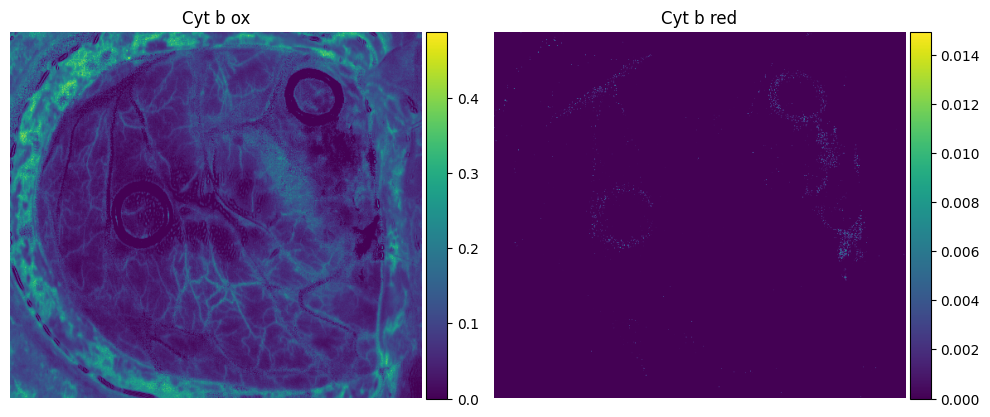

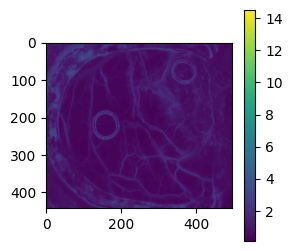

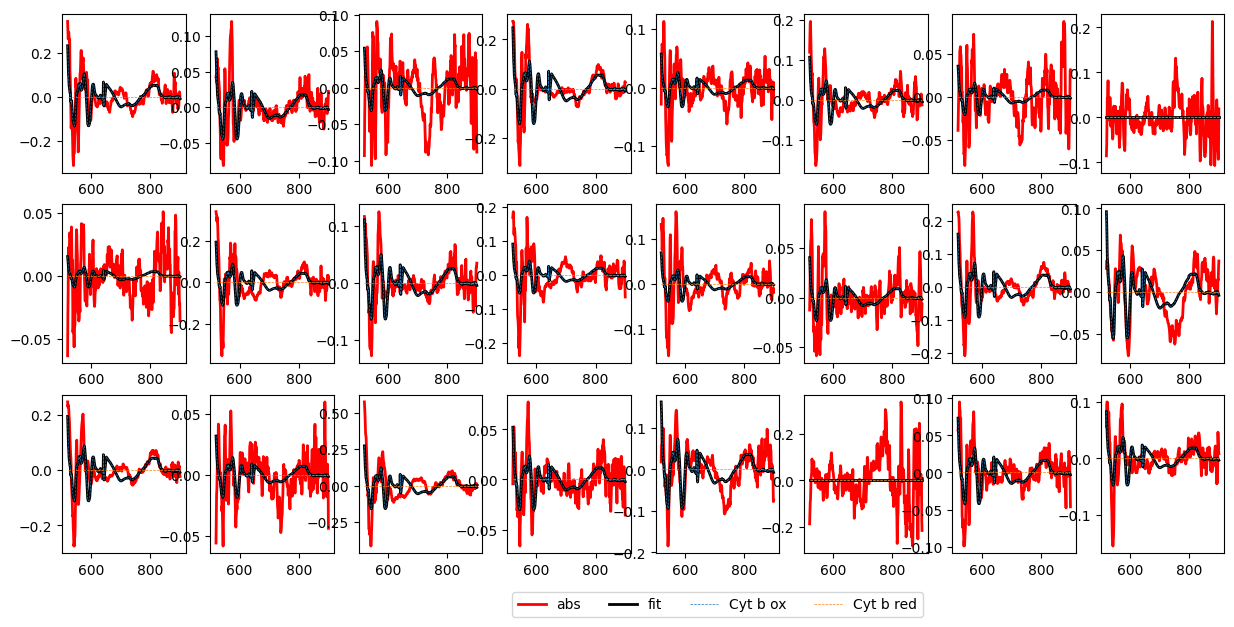

In [34]:
endmembers_proj_cyt_b = np.vstack((cyt_c_ox, cyt_c_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, ones, scatter_ray))
endmembers_unmix_cyt_b = np.vstack((cyt_b_ox, cyt_b_red))
absorbance_cyt_b_proj, endmembers_unmix_cyt_b_proj = project_absorbance(absorbance, endmembers_proj_cyt_b, endmembers_unmix_cyt_b, device="cuda")

M = endmembers_unmix_cyt_b_proj.T
c_cyt_b, err_cyt_b = unmix_LS_nonnegative(M, absorbance_cyt_b_proj)

endmember_labels=["Cyt b ox", "Cyt b red"]
plot_concentrations(c_cyt_b, endmember_labels, figsize=(10,5))

plot_error_img(err_cyt_b)

check_fit(c_cyt_b, M, absorbance_cyt_b_proj, endmember_labels)

hemoglobin

100%|██████████| 443/443 [00:03<00:00, 116.43it/s]


449.9003796311454


(<Figure size 1500x700 with 24 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >]], dtype=object))

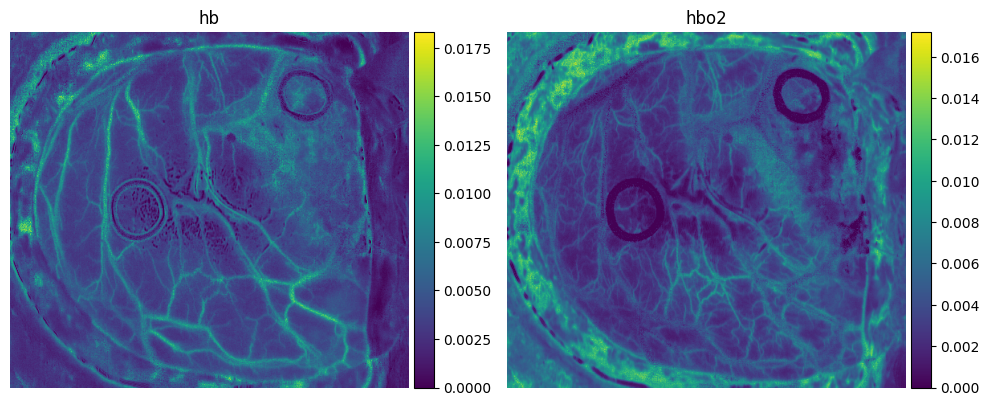

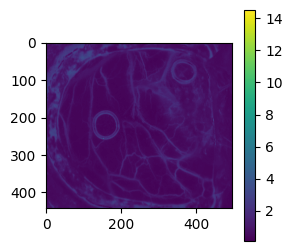

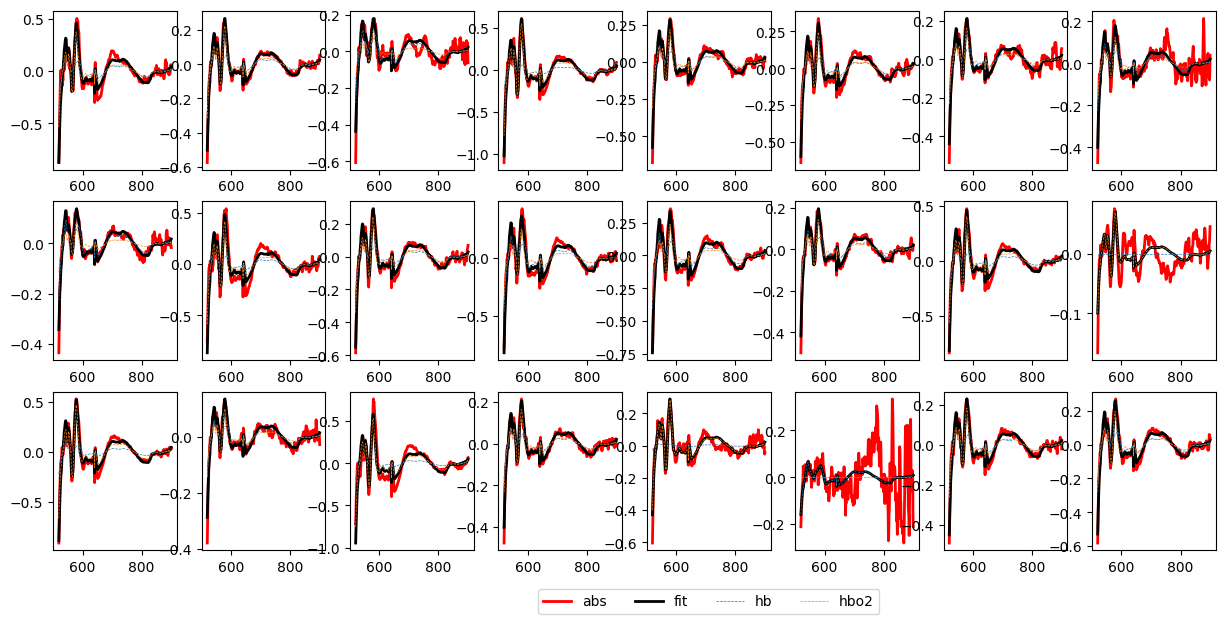

In [35]:
endmembers_proj_hb = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, water, fat, ones, scatter_ray))
endmembers_unmix_hb = np.vstack((hb, hbo2))
absorbance_hb_proj, endmembers_unmix_hb_proj = project_absorbance(absorbance, endmembers_proj_hb, endmembers_unmix_hb, device="cuda")

M = endmembers_unmix_hb_proj.T
c_hb, err_hb = unmix_LS_nonnegative(M, absorbance_hb_proj)

endmember_labels=["hb", "hbo2"]
plot_concentrations(c_hb, endmember_labels, figsize=(10,5))

plot_error_img(err_hb)

check_fit(c_hb, M, absorbance_hb_proj, endmember_labels)